In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from numpy.random import multivariate_normal as mvnorm
from numpy.linalg import norm

import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
%matplotlib inline

import pdb, time

seed = 0
np.random.seed(seed)

### Import and generate data

In [2]:
# Standardised Fama French 5 to industry portfolio 30
# Import data
data = pd.read_pickle("/Users/sikai/Downloads/ff5_30_standard_4000_draws.pkl")

# # Restrict to 100 time points
X = data[10:110].transpose(2, 1, 0)
X_cov = np.einsum('ijkl,jmkl->imkl', np.expand_dims(X, 1), np.expand_dims(X, 0))

### Train

In [3]:
n_dimensions, _, n_samples, time_steps = X_cov.shape
emp_inv = []
for i in range(time_steps):
    emp_inv.append(np.linalg.inv(np.mean(X_cov[:, :, :, i], 2)))
emp_inv = np.array(emp_inv)

In [47]:
from regain.covariance import TaylorProxTimeGraphicalLasso, TimeGraphicalLasso
tic = time.perf_counter()
tgl_tp = TaylorProxTimeGraphicalLasso(max_iter=10000, loss='LL', c_level=0.2, rho=1e3, theta=0.5, tol=1e-4, rtol=1e-4, psi="laplacian")
emp_inv_score_tp, baseline_score_tp, fit_score_tp, pre_tp = tgl_tp.fit_cov(X_cov).eval_cov_pre() 
toc = time.perf_counter()
print('Running Time :{}'.format(toc - tic))
# min_pre_tp = np.amin(np.abs(pre_tp[pre_tp != 0]))

UnboundLocalError: local variable 'trace_nabla_nabla' referenced before assignment

In [42]:
from regain.norm import l1_od_norm
from regain.validation import check_norm_prox
psi, prox_psi, psi_node_penalty = check_norm_prox(tgl_tp.psi)

def penalty_objective(Z_0, Z_1, Z_2, psi, theta):
    """Penalty-only objective function for time-varying graphical LASSO."""
    return theta * sum(map(l1_od_norm, Z_0)) + (1 - theta) * sum(map(psi, Z_2 - Z_1))

pre_tp_thres = {}
fit_score_tp_thres = {}
for i in [1e-4, 1e-6, 0]:
    pre_tp_thres[i] = np.array([k * (np.abs(k) >= i) for k in pre_tp])
    tgl_tp.precision_ = pre_tp_thres[i]
    emp_inv_score, baseline_score, fit_score_tp_thres[i], _ = tgl_tp.eval_cov_pre() 
    print(penalty_objective(pre_tp_thres[i], pre_tp_thres[i][:-1], pre_tp_thres[i][1:], psi, tgl_tp.theta))

9307.644105648485
9307.650971125022
9307.650973719801


In [25]:
np.save("tp_sol_ff5_ip30_20000_max_5_mult_3_div_2.npy", pre_tp)

In [10]:
from regain.covariance import CVXInequalityTimeGraphicalLasso, TimeGraphicalLasso
pre_cvx = np.load("mosek_sol_ff5_30_standard_alpha_0.2.npy")

In [11]:
from regain.norm import l1_od_norm
from regain.validation import check_norm_prox
psi, prox_psi, psi_node_penalty = check_norm_prox(tgl_tp.psi)

def penalty_objective(Z_0, Z_1, Z_2, psi, theta):
    """Penalty-only objective function for time-varying graphical LASSO."""
    return theta * sum(map(l1_od_norm, Z_0)) + (1 - theta) * sum(map(psi, Z_2 - Z_1))

pre = {}
fit_score = {}
# for i in [1e-2, 1e-3, 1e-4, 1e-6]:
for i in [1e-4]:
    pre[i] = np.array([k * (np.abs(k) >= i) for k in pre_cvx])
    tgl_tp.precision_ = pre[i]
    emp_inv_score, baseline_score, fit_score[i], _ = tgl_tp.eval_cov_pre() 
    print(penalty_objective(pre[i], pre[i][:-1], pre[i][1:], psi, tgl_tp.theta))

5951.380304945549


In [12]:
tgl = TimeGraphicalLasso(alpha=1., beta=1., mode='admm', rho=1, tol=1e-4,
            rtol=1e-4, psi='laplacian', max_iter=3000, verbose=False, assume_centered=False, 
            return_history=False, update_rho_options=None, compute_objective=True, 
            stop_at=None, stop_when=1e-4, suppress_warn_list=False, init='empirical')
fit_score_, pre_ = tgl.fit_cov(X_cov).eval_cov_pre()   

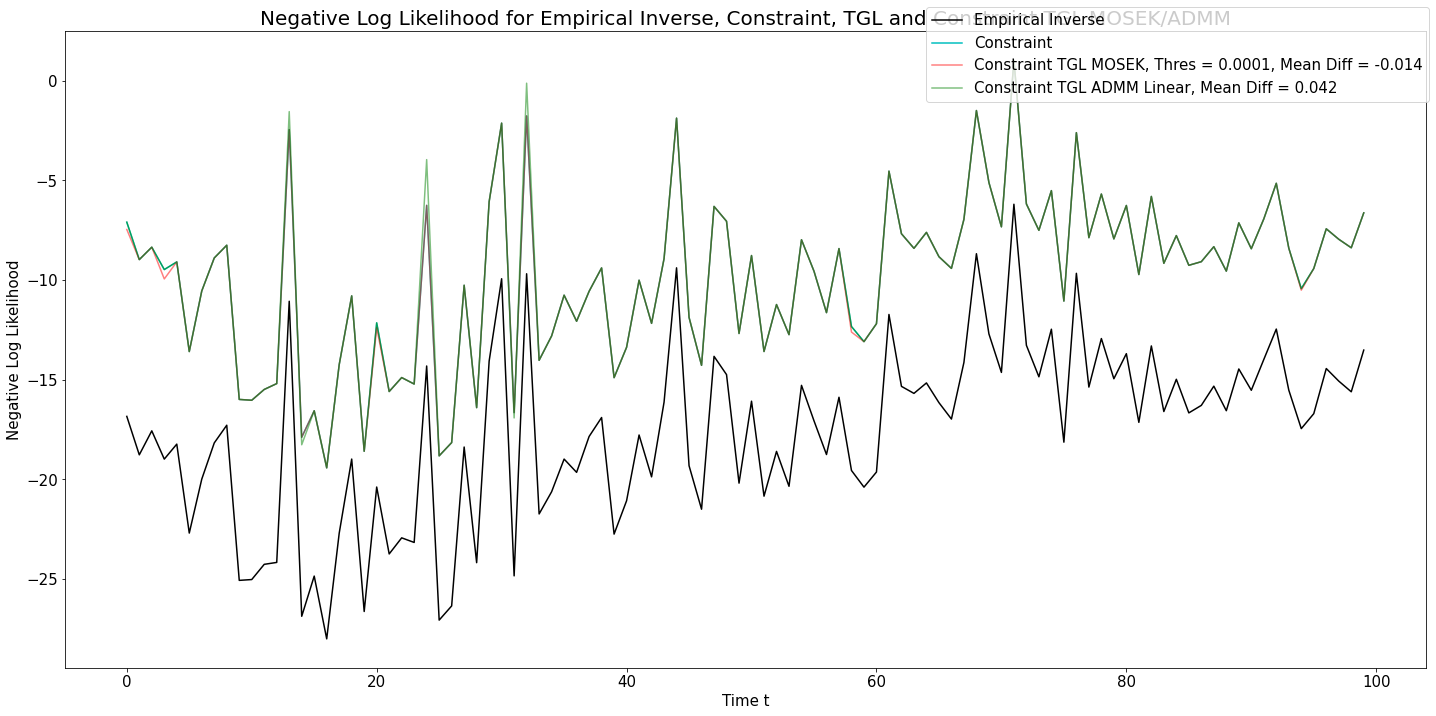

In [43]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('white')
colors = "rgb"
color_index = 0
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)

ax.plot(range(X_cov.shape[-1]), emp_inv_score_tp, color='k', label=r'Empirical Inverse')
ax.plot(range(X_cov.shape[-1]), baseline_score_tp, color='c', label=r'Constraint')
for i in [1e-4]:
    mean_diff = np.mean(np.array(fit_score[i]) - baseline_score)
    ax.plot(range(X_cov.shape[-1]), fit_score[i], color='r', alpha=0.5, 
#     ax.plot(range(X_cov.shape[-1]), fit_score[i], color=colors[color_index], alpha=0.5, 
            label=r'Constraint TGL MOSEK, Thres = {}, Mean Diff = {:.3f}'.format(i, mean_diff))
    color_index += 1
# mean_diff = np.mean(np.array(fit_score_grad) - baseline_score_grad)
# ax.plot(range(X_cov.shape[-1]), fit_score_grad, alpha=0.5, color='m',
#         label=r'Constraint TGL ADMM Gradient, Mean Diff = {:.3f}'.format(mean_diff))
# mean_diff = np.mean(np.array(fit_score_tp) - baseline_score_tp)
mean_diff = np.mean(np.array(fit_score_tp_thres[1e-4]) - baseline_score_tp)
# ax.plot(range(X_cov.shape[-1]), fit_score_tp, alpha=0.5, color='g',
ax.plot(range(X_cov.shape[-1]), fit_score_tp_thres[1e-4], alpha=0.5, color='g',
        label=r'Constraint TGL ADMM Linear, Mean Diff = {:.3f}'.format(mean_diff))
# mean_diff = np.mean(np.array(fit_score_) - res[1][1])
# ax.plot(range(X_cov.shape[-1]), fit_score_, color='y', label=r'Vanilla TGL, Mean Diff = {:.3f}'.format(mean_diff))

fig.legend(fontsize=15)
ax.set_ylabel('Negative Log Likelihood', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Time t', fontsize=15)
ax.set_title(r'Negative Log Likelihood for Empirical Inverse, Constraint, TGL and Constraint TGL MOSEK/ADMM', fontsize=20)
plt.tight_layout()
# plt.savefig('ff5_ip30_40000_diff_like_max_2_mult_3_div_5.pdf')

In [44]:
np.log(np.array(fit_score_tp_thres[1e-4]) - baseline_score_tp)

/Users/sikai/.pyenv/versions/3.7.6/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


array([         nan,          nan, -12.78233119,          nan,
       -25.22547639, -23.70844902, -12.17590528,  -9.52934634,
       -10.08225395, -14.61115073, -12.97742401, -10.74598965,
        -9.87895394,  -0.10090945,          nan, -10.78480436,
       -23.06636203, -10.37916835, -26.34105878,          nan,
       -25.23675773, -29.82107712, -10.50355664, -11.09702762,
         0.83027247, -12.19313197, -23.37038104, -14.5691647 ,
                nan, -26.95480291,          nan,          nan,
         0.49587008, -29.66014675, -13.09050524, -15.27924789,
       -12.26496177, -11.47081914,  -9.17513901, -23.2811013 ,
       -15.08660924,          nan, -23.06980858,          nan,
       -27.5284622 , -13.89504762,          nan,  -9.40919072,
       -13.66596907,          nan,          nan, -10.02786361,
        -9.52025183,          nan, -10.07059353, -13.19683764,
       -11.54266701, -11.62923381, -11.35963936,          nan,
       -10.37614933, -10.81220956,          nan,  -9.45

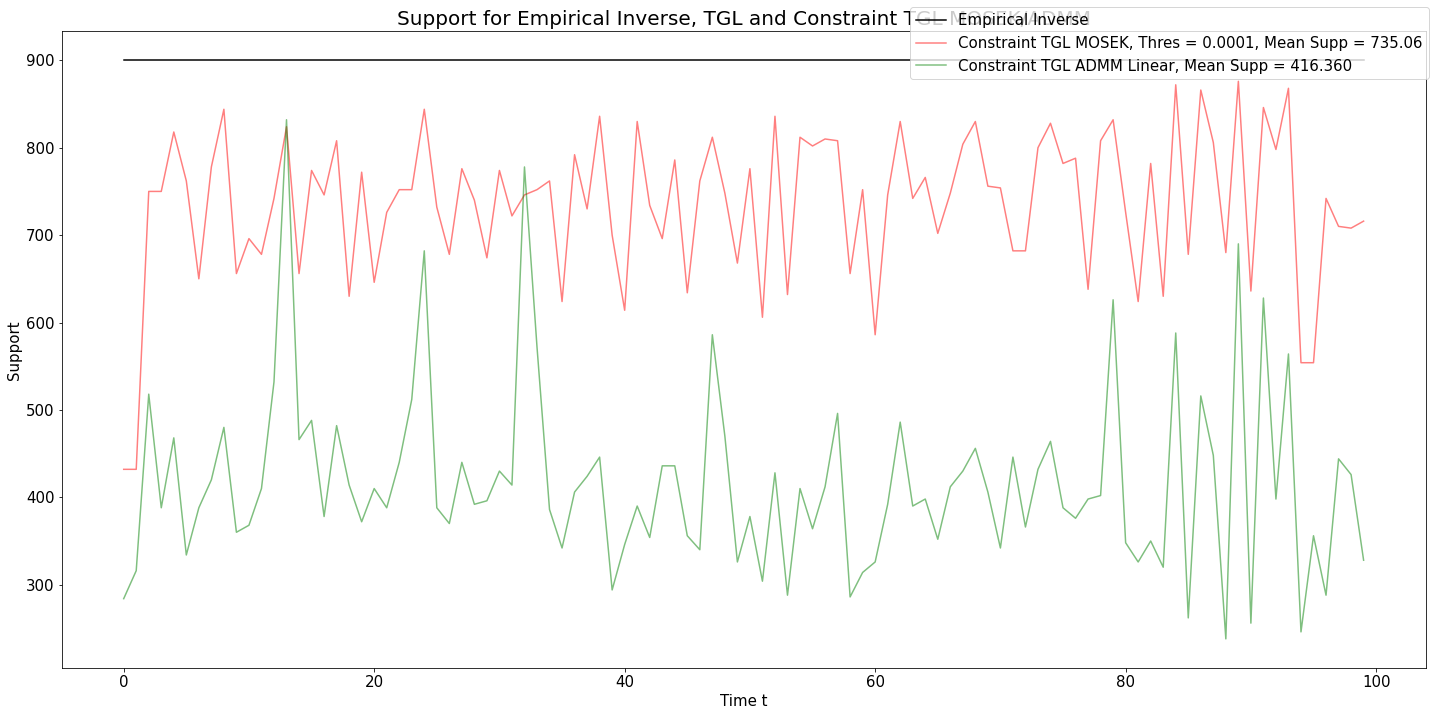

In [45]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('white')
colors = "rgb"
color_index = 0

ax.plot(range(X_cov.shape[-1]), [sum(sum(abs(emp_inv[k]) > 0)) for k in range(X_cov.shape[-1])], 
        color='k', label=r'Empirical Inverse')
# for i in [min_pre_tp]:
for i in [1e-4]:
    supp = [sum(sum(abs(pre[i][t]) > 0)) for t in range(X_cov.shape[-1])]
    mean_supp = np.mean(supp)
    ax.plot(range(X_cov.shape[-1]), supp, color='r', alpha=0.5, 
#     ax.plot(range(X_cov.shape[-1]), supp, color=colors[color_index], alpha=0.5, 
            label=r'Constraint TGL MOSEK, Thres = {}, Mean Supp = {}'.format(i, mean_supp))
    color_index += 1
# supp = [sum(sum(abs(pre_grad[t]) > 0)) for t in range(X_cov.shape[-1])]
# ax.plot(range(X_cov.shape[-1]), supp, color='m', alpha=0.5,
#         label=r'Constraint TGL ADMM Gradient, Mean Supp = {:.3f}'.format(np.mean(supp)))
supp = [sum(sum(abs(pre_tp_thres[1e-4][t]) > 0)) for t in range(X_cov.shape[-1])]
# supp = [sum(sum(abs(pre_tp[t]) > 0)) for t in range(X_cov.shape[-1])]
ax.plot(range(X_cov.shape[-1]), supp, color='g', alpha=0.5,
        label=r'Constraint TGL ADMM Linear, Mean Supp = {:.3f}'.format(np.mean(supp)))
# supp = [sum(sum(abs(pre_[t]) > 0)) for t in range(X_cov.shape[-1])]
# ax.plot(range(X_cov.shape[-1]), [sum(sum(abs(pre_[k]) > 0)) for k in range(X_cov.shape[-1])], 
#         color='y', label=r'Vanilla TGL, , Mean Supp = {:.3f}'.format(np.mean(supp)))


fig.legend(fontsize=15)
ax.set_ylabel('Support', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Time t', fontsize=15)
ax.set_title(r'Support for Empirical Inverse, TGL and Constraint TGL MOSEK/ADMM', fontsize=20)
plt.tight_layout()
plt.savefig('ff5_ip30_40000_diff_supp_max_2_mult_3_div_5.pdf')

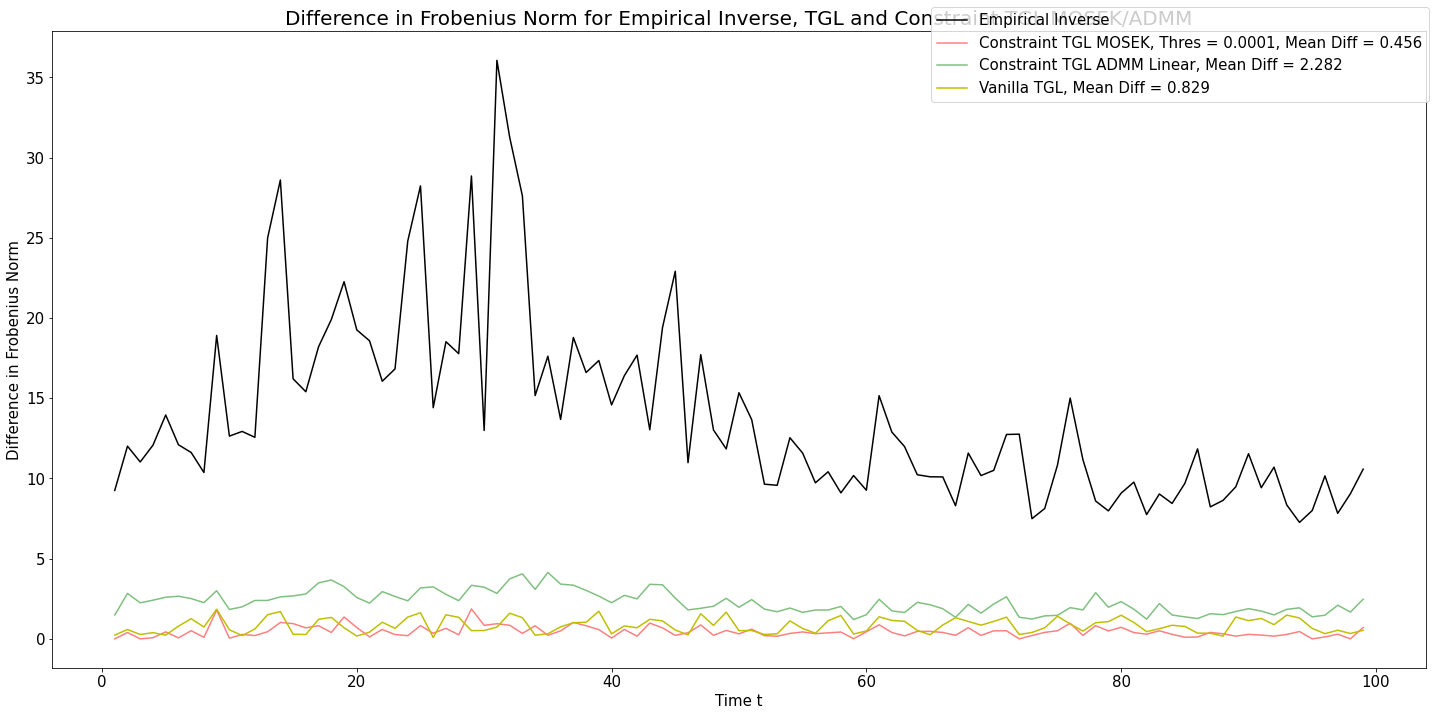

In [46]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('white')
colors = "rgb"
color_index = 0

diff_emp = [norm(emp_inv[t] - emp_inv[t-1], 'fro') for t in range(1, X_cov.shape[-1])]
ax.plot(range(1, X_cov.shape[-1]), np.array(diff_emp), alpha=1, color='k', label=r'Empirical Inverse')
# for i in [min_pre_tp]:
for i in [1e-4]:
    diff = [norm(pre[i][t] - pre[i][t-1], 'fro') for t in range(1, X_cov.shape[-1])]
    mean_diff = np.mean(diff)
    ax.plot(range(1, X_cov.shape[-1]), diff, color='r', alpha=0.5, 
#     ax.plot(range(1, X_cov.shape[-1]), diff, color=colors[color_index], alpha=0.5, 
            label=r'Constraint TGL MOSEK, Thres = {}, Mean Diff = {:.3f}'.format(i, mean_diff))
    color_index += 1
# diff_grad = [norm(pre_grad[t] - pre_grad[t-1], 'fro') for t in range(1, X_cov.shape[-1])]
# ax.plot(range(1, X_cov.shape[-1]), diff_grad, color='m', alpha=0.5,
#         label=r'Constraint TGL ADMM Gradient, Mean Diff = {:.3f}'.format(np.mean(diff_grad)))
diff_grad = [norm(pre_tp_thres[1e-4][t] - pre_tp_thres[1e-4][t-1], 'fro') for t in range(1, X_cov.shape[-1])]
# diff_grad = [norm(pre_tp[t] - pre_tp[t-1], 'fro') for t in range(1, X_cov.shape[-1])]
ax.plot(range(1, X_cov.shape[-1]), diff_grad, color='g', alpha=0.5,
        label=r'Constraint TGL ADMM Linear, Mean Diff = {:.3f}'.format(np.mean(diff_grad)))
diff_fit_ = [norm(pre_[t] - pre_[t-1], 'fro') for t in range(1, X_cov.shape[-1])]
ax.plot(range(1, X_cov.shape[-1]), np.array(diff_fit_), color='y', alpha=1, 
        label=r'Vanilla TGL, Mean Diff = {:.3f}'.format(np.mean(diff_fit_)))

fig.legend(fontsize=15)
ax.set_ylabel('Difference in Frobenius Norm', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Time t', fontsize=15)
ax.set_title(r'Difference in Frobenius Norm for Empirical Inverse, TGL and Constraint TGL MOSEK/ADMM', fontsize=20)
plt.tight_layout()
plt.savefig('ff5_ip30_40000_diff_fro_max_2_mult_3_div_5.pdf')